# Generate XTB initial dataset
Generate a few thousand XTB molecules as an initial dataset. See how the atomization energy compares to Gaussian

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moldesign.simulate import relax_structure, compute_reference_energy, subtract_reference_energies
from qcelemental.models.procedures import QCInputSpecification, Model
from qcelemental.models import Molecule
from qcengine.util import compute_wrapper
from qcengine import compute
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

/home/wardlt/miniconda3/envs/colmena_full/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


In [2]:
multiplicity = {'H': 2, 'He': 1, 'Li': 2, 'C': 3, 'N': 4, 'O': 3, 'F': 2}

In [3]:
qm9_ref_energies = {'C': -37.846772, 'H': -0.500273, 'O':  -75.064579, 
                    'N': -54.583861, 'Li': -7.491464, 'F':  -99.718730}

## Load QM9 Data
It is the training data for our MPNN

In [4]:
qm9 = pd.concat(pd.read_csv(os.path.join('..', '..', '..', 'notebooks', 'mpnn-atomization-energy', f'{x}.csv'))
                for x in ['train', 'test', 'valid'])

## Define the QC Specification

In [5]:
spec = QCInputSpecification(model=Model(method='GFN2-xTB', keywords={'accuracy': 0.05}))

## Compute Reference Energies
It is somehow different between codes

In [6]:
ref_energies = dict((e, compute_reference_energy(e, spec, multiplicity[e], 'xtb')) for e in tqdm(qm9_ref_energies))

100%|██████████| 6/6 [00:00<00:00, 10.38it/s]


In [7]:
all_ref_energies = pd.DataFrame({'xtb': ref_energies, 'qm9': qm9_ref_energies})

In [8]:
all_ref_energies

,xtb,qm9
C,-1.793296,-37.846772
H,-0.393483,-0.500273
O,-3.767607,-75.064579
N,-2.605824,-54.583861
Li,-0.180072,-7.491464
F,-4.619340,-99.718730


They are indeed very different. We must compare atomization energies

## Compute Atomization Energies
For a few molecules

In [9]:
test_rows = qm9.sort_values('n_heavy_atoms', ascending=True).sample(1024, random_state=1)
print(f'Selected {len(test_rows)} molecules')

Selected 1024 molecules


In [10]:
for rid, row in tqdm(test_rows.iterrows()):
    try:
        xyz, eng = relax_structure(row['smiles_0'], spec, code='xtb')
    except:
        continue
    test_rows.loc[rid, 'xtb_u_e'] = eng
    test_rows.loc[rid, 'xtb_xyz'] = xyz

1024it [1:54:35,  6.71s/it]


Drop rows that did not converge

In [11]:
failed = test_rows['xtb_u_e'].isnull()
print(f'{failed.sum()}/{len(failed)} ({failed.mean() * 100:.1f}%) of relaxations failed')
test_rows = test_rows[~failed]

14/1024 (1.4%) of relaxations failed


See how different the geometries are, based on RMSD

In [31]:
test_rows['rmsd'] = test_rows.apply(
    lambda x: Molecule.from_data(x['xyz']).align(Molecule.from_data(x['xtb_xyz']), atoms_map=True)[1]['rmsd'], 
    axis=1)

INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returned_mol NRE uncorrupted........PASSED
INFO:root:    Q: concern_mol-->returne

Text(0, 0.5, 'Frequency')

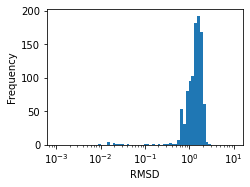

In [36]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.hist(test_rows['rmsd'], bins=np.logspace(-3, 1, 64))
ax.set_xscale('log')
ax.set_xlabel('RMSD')
ax.set_ylabel('Frequency')

*Finding*: They are very different. Definitely evident that this is semi-empircal

How different are the atomizations?

In [17]:
test_rows['xtb_u_e_atom'] = test_rows.apply(lambda x: subtract_reference_energies(
    x['xtb_u_e'], Molecule.from_data(x['xyz']), ref_energies
), axis=1)

Text(0, 0.5, 'Frequency')

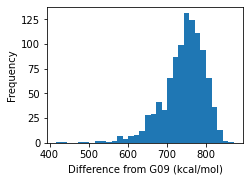

In [35]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

errors = (test_rows['u0_atom'] - test_rows['xtb_u_e_atom']) * 627.50947406
ax.hist(errors, bins=32)
ax.set_xlabel('Difference from G09 (kcal/mol)')
ax.set_ylabel('Frequency')

*Finding*: The absolute value of the errors are enormous

How about the correlation?

Text(0, 0.5, '$U_{0}$, TB (Ha)')

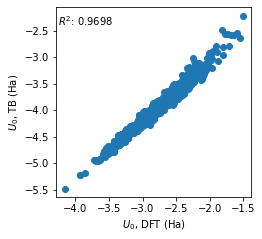

In [33]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_rows['u0_atom'], test_rows['xtb_u_e_atom'])
r2 = np.corrcoef(test_rows['u0_atom'], test_rows['xtb_u_e_atom'])[0][1] ** 2
ax.text(0.01, 0.9, f'$R^2$: {r2:.4f}', transform=ax.transAxes)

ax.set_xlabel('$U_{0}$, DFT (Ha)')
ax.set_ylabel('$U_{0}$, TB (Ha)')

*Finding*: At least the correlation is high!

Save it all to disk using CSV format

In [34]:
test_rows.to_csv('xtb_energies.csv', index=False)